# Exploring Data

The previous two notebooks were more about cleaning and formatting the data than actually exploring it. This notebook will be focused on exploring the data, relationships between variables, variations over time, etc. I will create some intitial visualizations to give some context as to the problem my analysis is hoping to solve. I will probably perform some basic time series analysis on the energy output as well.

### Visualization Ideas:
- Energy output variation with time (season/daily/hourly)
- Relationships between energy output and weather conditions
- Weather variation with time

### NOTE
When constructing models, the dataframe will be formatted to include a three hour lag between weather conditions and energy output. This is to allow my model's to predict energy output three hour's in the future with the current weather observations. The dataframe's in this notebook will not include that lag, as I am trying to explore the relationship betweene solar energy production and the weather conditions at the time of production.

### Import Libraries and Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Use functions from .py file
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import src.data_gathering as dg

In [3]:
energy = dg.energy_data()
weather = dg.weather_data()

I know from the notebook 03_first_model that the weather data function does not work entirely as intended. So i need to check to see if additional formatting/cleaning is needed. As well as perform the cleaning not done by the functions.

In [4]:
cols_with_letter = dg.columns_with_letter(weather)

In [5]:
cols_with_letter

array(['HourlyPrecipitation', 'HourlyVisibility', 'HourlyWindDirection'],
      dtype='<U19')

So three columns still have letters present, i need to take those out before I can convert the column types to float.

In [6]:
let_in_precip = dg.letter_in_column(weather['HourlyPrecipitation'])
let_in_visib = dg.letter_in_column(weather['HourlyVisibility'])
let_in_wind = dg.letter_in_column(weather['HourlyWindDirection'])

In [7]:
weather['HourlyPrecipitation'] = dg.remove_letter_from_column(weather, 'HourlyPrecipitation', let_in_precip)
weather['HourlyVisibility'] = dg.remove_letter_from_column(weather, 'HourlyVisibility', let_in_visib)
weather['HourlyWindDirection'] = dg.remove_letter_from_column(weather, 'HourlyWindDirection', let_in_wind)

Now I can double check that all letters were removed.

In [8]:
dg.columns_with_letter(weather)

array(['HourlyWindDirection'], dtype='<U19')

In [9]:
letter_in_wind = dg.letter_in_column(weather['HourlyWindDirection'])

In [10]:
weather['HourlyWindDirection'] = dg.remove_letter_from_column(weather, 'HourlyWindDirection', letter_in_wind)

In [11]:
dg.columns_with_letter(weather)

array([], dtype=float64)

There seemed to be two letter's present in 'HourlyWindDirection'. That is most likely why the function is not performing properly. It assumes there is only one letter present in a given column, but there may be multiple different letter's present. That will be an easy fix. Next I will drop all rows at time '23:59:00' because this time has primarily missing values and is not relevant for analysis as no energy is produced at this time.

In [12]:
to_drop = weather[(weather.index.hour == 23) & (weather.index.minute == 59)].index

In [13]:
weather.drop(to_drop, axis=0, inplace=True)

Next I need to convert all value's of 'T' in 'HourlyPrecipitation' to 0. 'T' indicates trace amount of precipitation. The smallest value other than 0 is 0.01, so I think anything less than that is safe to consider 0.

In [19]:
weather['HourlyPrecipitation'] = ['0.00' if val == '' else val for val in weather['HourlyPrecipitation']]

In [20]:
weather['HourlyPrecipitation'].value_counts()

0.00    21424
0.01      807
0.02      412
0.03      266
0.04      200
        ...  
0.87        1
0.94        1
0.64        1
1.03        1
0.78        1
Name: HourlyPrecipitation, Length: 96, dtype: int64

The final cleaning step I need to perform is taking care of the star values present in a few columns. Previously, I converted these values to np.nan and imputed them along with the other missing values, but after further consideration i am not sure this is the best method. The reason being the documentation says these amounts are included in the next measurement, meaning the value is still accounted for. I am going to do as I did earlier for now, but this is something I need to consider further. There are only 11 row's where a star value is present, so dropping or imputing really won't affect model performance too much. When in doubt, I'd prefer more data, so that is the method I will do for now.

In [25]:
weather['HourlyDewPointTemperature'].loc[weather['HourlyDewPointTemperature'] == '*'] = np.nan
weather['HourlyDryBulbTemperature'].loc[weather['HourlyDryBulbTemperature'] == '*'] = np.nan
weather['HourlyRelativeHumidity'].loc[weather['HourlyRelativeHumidity'] == '*'] = np.nan
weather['HourlyVisibility'].loc[weather['HourlyVisibility'] == '*'] = np.nan

Now that those values are taken care of, I can impute the missing values with IterativeImputer as I did in the previous notebook and aggregate for hourly time index.

In [27]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [28]:
imp = IterativeImputer(random_state=42)

In [30]:
weather = weather.astype(float)

ValueError: could not convert string to float: 

There seems to be an empty string present somewhere in the 'HourlyWindDirection' column. The documentation states that blank values should be treated as null, so I am going to convert all missing values to np.nan

In [37]:
weather['HourlyWindDirection'] = weather['HourlyWindDirection'].replace('', np.nan)

In [38]:
weather = weather.astype(float)

Now that all of the data is in numerical format, I can impute the missing values.

In [39]:
weather_imputed = imp.fit_transform(weather)

IterativeImputer returns a numpy array. I can convert this back to a dataframe using pd.DataFrame and the index and columns of the weather dataframe

In [40]:
weather_df = pd.DataFrame(index=weather.index, columns=weather.columns, data=weather_imputed)

## Explore Energy Data

Now I can begin to actually explore the data. I will start by creating some of the visualizations listed at the beginning of the notebook. I will begin by looking at the energy data across time.

In [41]:
energy.head()

,nexus_meter,inverter
time,,
2018-01-30 00:00:00,0.0,0.0
2018-01-30 01:00:00,0.0,0.0
2018-01-30 02:00:00,0.0,0.0
2018-01-30 03:00:00,0.0,0.0
2018-01-30 04:00:00,0.0,0.0


The inverted variable gives information on the conversion of DC power (generated from solar panel) to AC power (distributed to grid). This information is not very useful for my analysis at this point, so I am going to remove that column

In [44]:
energy.drop('inverter', axis=1, inplace=True)

I want to begin by looking at how daily solar energy production fluctuates over time, as well as how hourly energy production fluctuates over a day. To aggregate for daily power generation, I will sum up the solar energy production of each hour into it's respective day.

In [54]:
daily_energy = energy.resample('D').sum()

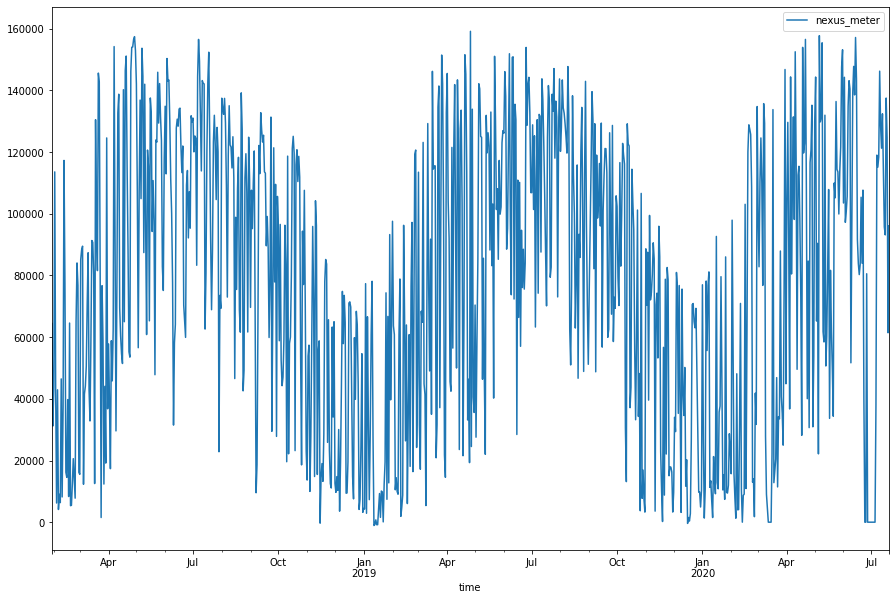

In [55]:
daily_energy.plot(figsize=(15, 10))

From the plot above it's pretty clear that the daily energy production flucutates drastically throughout the year. Reaching it's minimum in what looks like late November, early December and lasting through February and March. Then quicly rises to it's peak in Spring months, lasting for the most part throughout the Summer and beginning to decline again in Fall. It's important to note that this is the overall trend, and this is a lot of noise in the dataset (a sunny day in January will produce more energy than a cloudy day in June). I want to create a few more plots highlighting this overall trend before looking at more granular time frames.

In [74]:
daily_roll_mean = daily_energy.rolling(30).mean()

I did a window size of 30 to capture the trend on a month to month basis.

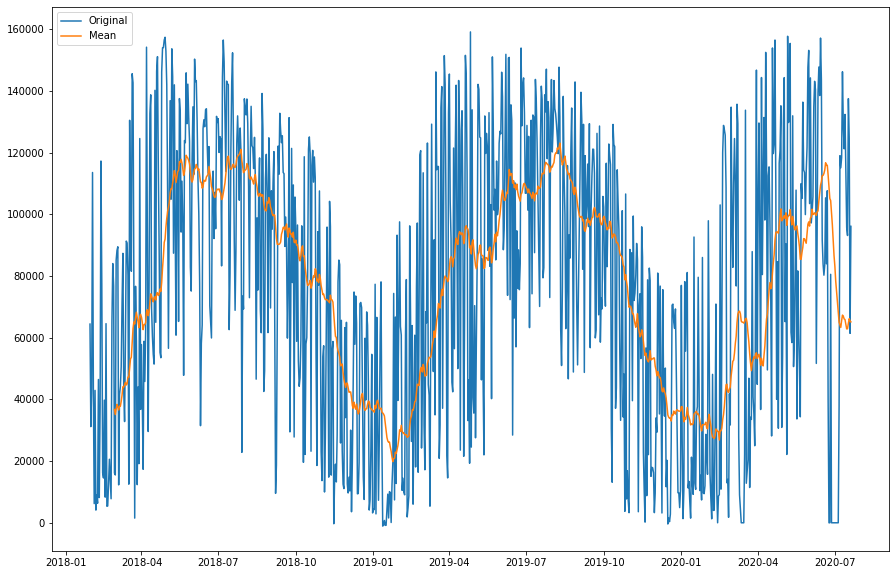

In [75]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(daily_energy, label='Original')
ax.plot(daily_roll_mean, label='Mean')
ax.legend(loc='best')

The plot above highlights the seasonal trend. Although there is substantial noise in solar energy production on a day to day basis, the overall trend shows that energy production is much higher on average during Spring and Summer months that in Winter months. Plotting the rolling standard deviation over the same window frame should be a good visual of the noise on the data

In [76]:
daily_roll_std = daily_energy.rolling(30).std()

### Seasonal Fluctuation with trend

Text(0, 0.5, 'Energy Production (kWh)')

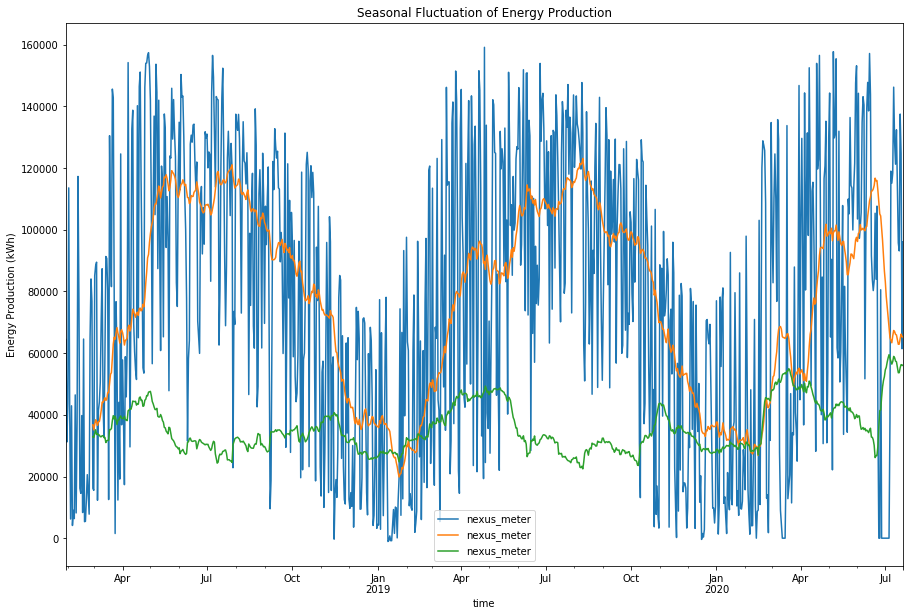

In [91]:
fig, ax = plt.subplots(figsize=(15,10))
daily_energy.plot(ax=ax, label='Original')
daily_roll_mean.plot(ax=ax, label='Mean')
daily_roll_std.plot(ax=ax, label='Std')
ax.legend(loc='best')
ax.set_title('Seasonal Fluctuation of Energy Production')
ax.set_ylabel('Energy Production (kWh)')

The standard deviation highlights the more granular fluctuations in the data. If the data followed the trend tightly (less noise), the standard deviation would be much less pronounced. However since the standard deviation plot goes up and down a lot, it illustrates how much the energy production can vary within a short time period (day to day).

Text(0, 0.5, 'Energy Production (kWh)')

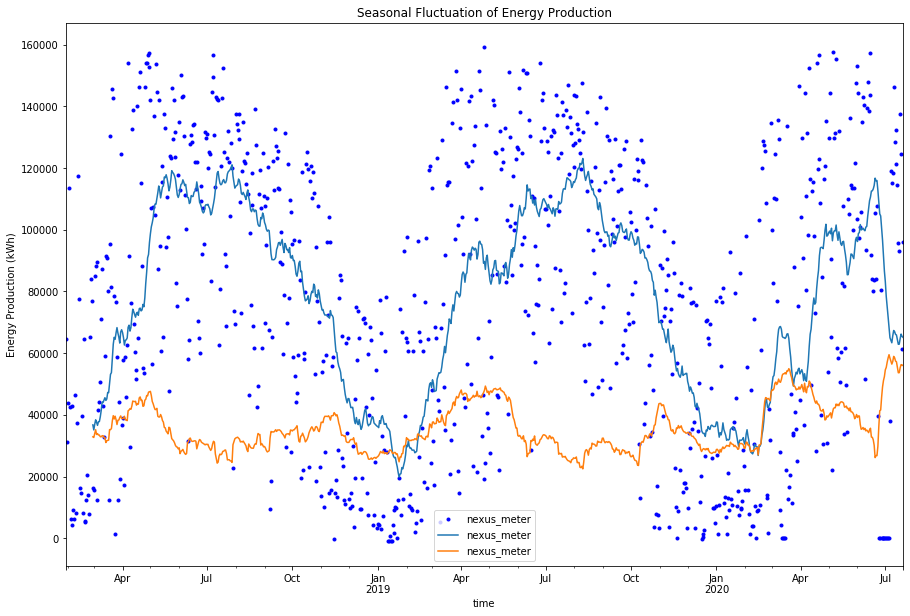

In [92]:
fig, ax = plt.subplots(figsize=(15,10))
daily_energy.plot(ax=ax, style='.b', label='Original')
daily_roll_mean.plot(ax=ax, label='Mean')
daily_roll_std.plot(ax=ax, label='Std')
ax.legend(loc='best')
ax.set_title('Seasonal Fluctuation of Energy Production')
ax.set_ylabel('Energy Production (kWh)')

I think the plot above does a much better job illustrating the variation of energy production within a short time period. Each dot represents the energy production on a given day. As you can see the overall trend of the dots still follow the 30 day rolling mean (green line), however the dots are still all over the place. Focusing on a given month (January 2019) one dot can be at the very bottom of the plot, and the next is closer to the top. This emphasizes the idea that although energy production is dependent on time of year, the weather on any given day is the primary predictor of energy production. Now I want to look at energy production on a more granular level. 

### Monthly energy fluctuation

I want to see how energy production fluctuates within a given month. I will choose four months from 2019 to include seasonal variation as well. The months will be January, April, July, and October to include one month from each season. To keep things consistent I will choose the first day to the thirtieth day of each month.

In [107]:
january = energy['2019-01-01': '2019-01-30']
april = energy['2019-04-01': '2019-04-30']
july = energy['2019-07-01': '2019-07-30']
october = energy['2019-10-01': '2019-10-30']

In [108]:
daily_generation = [january, april, july, october]
titles = ['January', 'April', 'July', 'October']

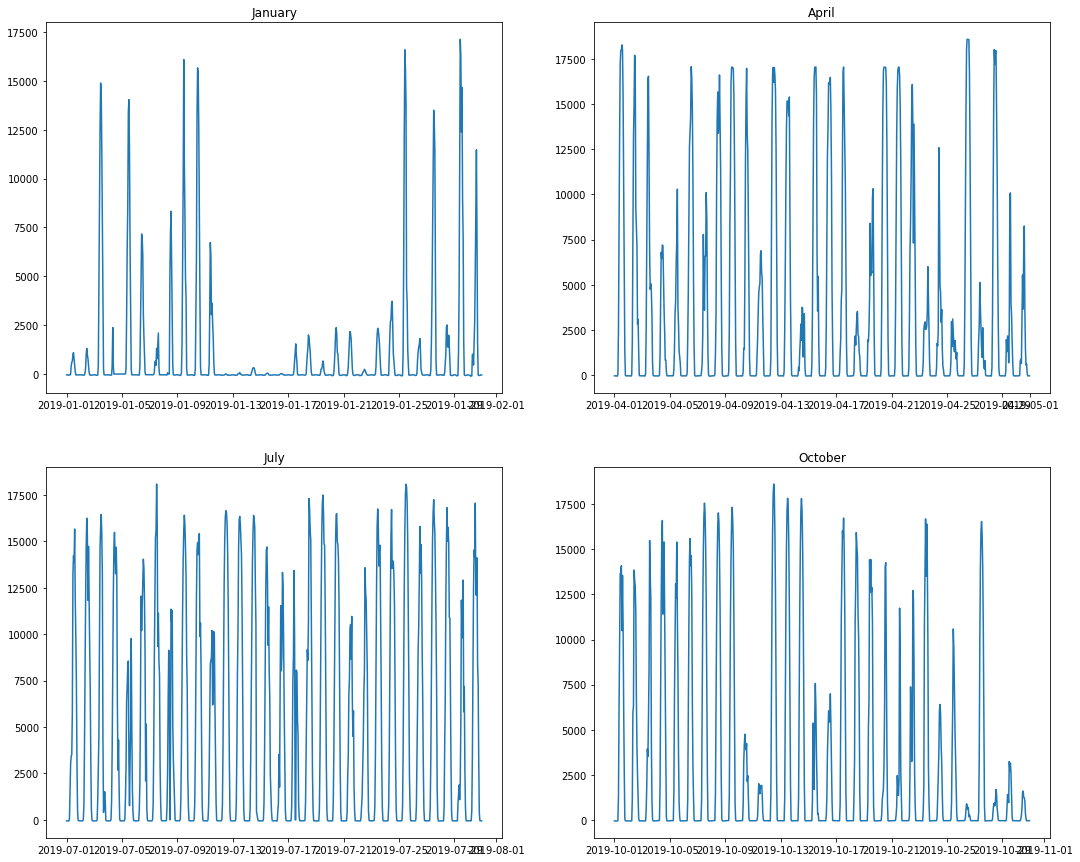

In [109]:
fig, ax = plt.subplots(2, 2, figsize=(18, 15))
i=0
for row in range(2):
    for col in range(2):
        ax[row][col].plot(daily_generation[i])
        ax[row][col].set_title(titles[i])
        i += 1

A few important takeaways from the plot above:
- January has a few days where the energy production was close to that of April or July. Winter months CAN have high energy production, it's just much less common
- This solar farm is located in the midwest, where Winter days are much shorter than Spring and Summer days. So weather held constant, the sun is rising later and setting earlier in the Winter, resulting in less solar energy generation.
- This is more of an intuition than anything, but I think Summer months have less overall precipitation and cloud cover which means there would be more solar radiation reaching the solar farm than Spring, Fall, and, Winter months which bring more rain and snow than Summer months.

January and July differ the most out of the plots above, so I want to look at those plots more closely.

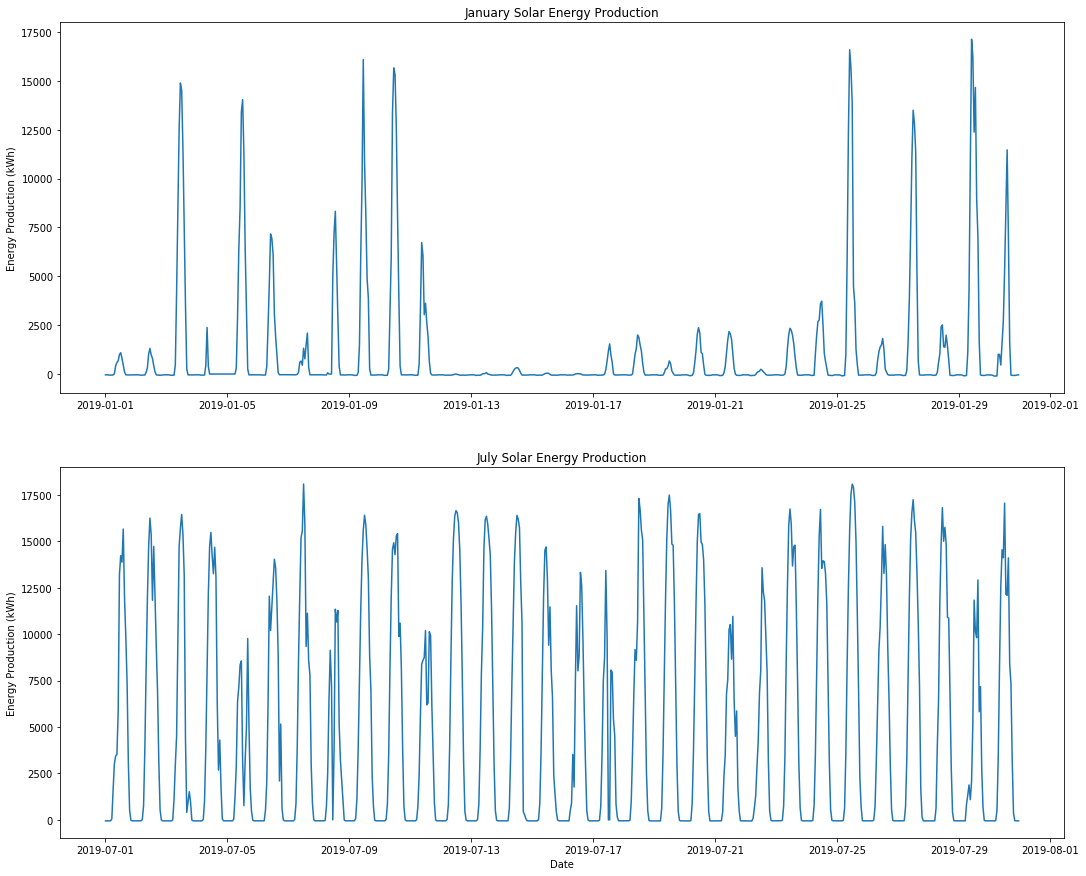

In [113]:
fig, ax = plt.subplots(2, 1, figsize=(18, 15))
ax[0].plot(january)
ax[0].set_title('January Solar Energy Production')
ax[0].set_ylabel('Energy Production (kWh)')
ax[1].plot(july)
ax[1].set_title('July Solar Energy Production')
ax[1].set_xlabel('Date')
ax[1].set_ylabel("Energy Production (kWh)");

This plot above really highlights a few of the points discussed with the previous plot. Although a few day's in January produce about as much energy as day in July, those day's are very infrequent. The average day in January produces very little energy. Another thing that may be affecting this is snow. If a snowfall is covering the solar panels, even if the sun is out there is now way for the panels to produce energy.

There is a point made from the previous plot that I want to explore more. That is that Summer months have less precipiation than other months (ie less overall cloud cover). I am going to explore this theory using the weather data from 2019.

## Exploring Weather data

The first thing I want to check is cloud coverage in different seasons. I think there is less overall cloud coverage in Summer than in other months (especially Winter and Spring). Increased cloud cover will severely inhibit energy production from solar sources.

In [114]:
# subset weather dataframe for 2019
weather_2019 = weather_df['2019-01-01': '2019-12-31']

According to National Geographic, Spring begins March 1, Summer begins June 1, fall begins September 1, and Winter on December 1. I may change this splits but for now i will use this to define the seasons.

In [116]:
spring_2019 = weather_2019['2019-03-01': '2019-05-30']
summer_2019 = weather_2019['2019-06-01': '2019-08-30']
fall_2019 = weather_2019['2019-09-01': '2019-11-30']
winter_2019 = weather_2019[: '2019-02-28']

In [118]:
avg_summer_clouds = np.mean(summer_2019['cloud_coverage'].values)
avg_spring_clouds = np.mean(spring_2019['cloud_coverage'].values)
avg_fall_clouds = np.mean(fall_2019['cloud_coverage'].values)
avg_winter_clouds = np.mean(winter_2019['cloud_coverage'].values)

In [138]:
clouds_seasons = [avg_winter_clouds, avg_spring_clouds, avg_summer_clouds, avg_fall_clouds]
x = ['Winter', 'Spring', 'Summer', 'Fall']

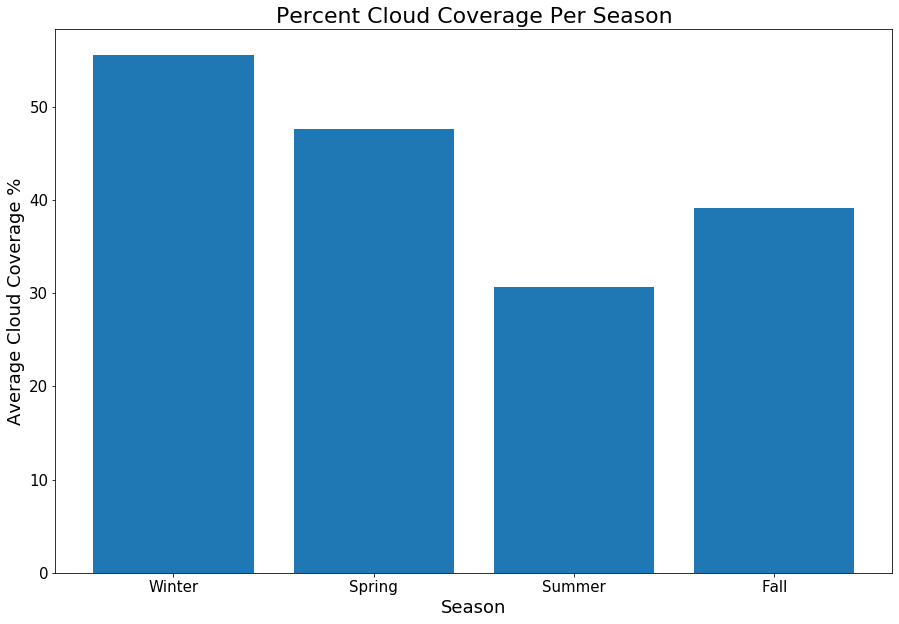

In [150]:
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(x, clouds_seasons)
ax.set_title('Percent Cloud Coverage Per Season', fontsize=22)
ax.set_xlabel('Season', fontsize=18)
ax.set_ylabel('Average Cloud Coverage %', fontsize=18)
ax.tick_params(which='major', labelsize= 15)

Average cloud coverage is much lower in the Summer than it is in the Winter, which is likely to have some attribution to higher energy production in the Summer than Winter. Fall has the second lowest cloud coverage. It's important to note that this is only looking at one year and that cloud coverage varies from year to year. But for the specific time period this analysis is focused on, cloud coverage is likely to be a significant predictor of solar energy production. I want to look a little deeper, and see how average cloud coverage varies on a month to month basis.

### Average cloud coverage per month

First I need to get average cloud coverage for each month of 2019.

In [169]:
monthly_cloud_coverage = weather_2019.groupby(pd.Grouper(freq='M'))['cloud_coverage'].mean().values

In [170]:
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

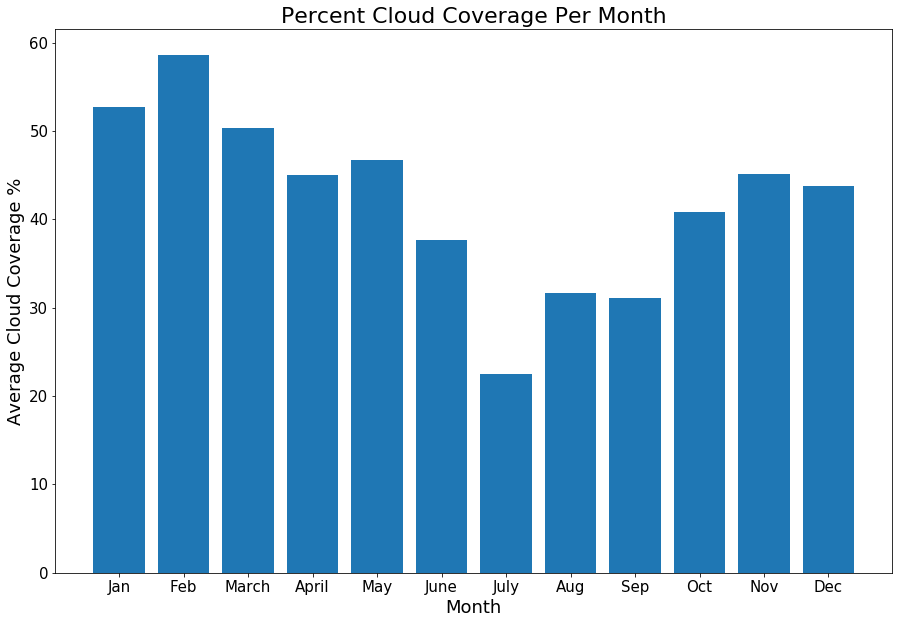

In [171]:
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(months, monthly_cloud_coverage)
ax.set_title('Percent Cloud Coverage Per Month', fontsize=22)
ax.set_xlabel('Month', fontsize=18)
ax.set_ylabel('Average Cloud Coverage %', fontsize=18)
ax.tick_params(which='major', labelsize= 15)

This plot's results reflect the seasonal cloud coverage plot. Cloud coverage is much lower on average in the Summer, with July being significantly lower than other months. I want to see how this influences energy production, so i am going to plot total monthly energy production for 2019.

In [172]:
energy_2019 = energy['2019-01-01': '2019-12-31']

In [173]:
monthly_energy_production = energy_2019.groupby(pd.Grouper(freq='M'))['nexus_meter'].sum().values

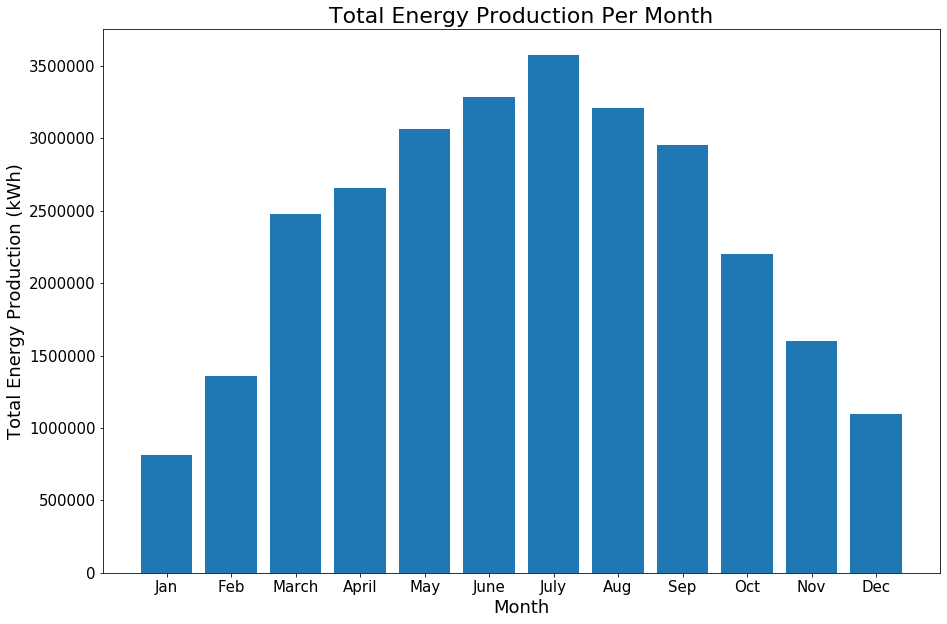

In [174]:
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(months, monthly_energy_production)
ax.set_title('Total Energy Production Per Month', fontsize=22)
ax.set_xlabel('Month', fontsize=18)
ax.set_ylabel('Total Energy Production (kWh)', fontsize=18)
ax.tick_params(which='major', labelsize= 15)

Total energy production follows the cloud coverage plot very closely. Obviously it does not line up perfectly as there are other weather conditions that factor into energy production. For that reason, before I explore more of the weather features, I want to investigate the correlation between the various weather conditions energy production.

## Correlation between weather conditions and solar energy production

When modeling, I incorporate a three hour lag between weather conditions and energy output to account for the three hour forecast. For the purposes of this exploration I will ignore this lag. I am focused specifically on what weather conditions influence energy production at the time of observation. First thing I need to do is aggregate the weather data to hourly format.

In [177]:
weather_hourly = weather_df.resample('H').mean()

In [190]:
# create base dataframe
base_df = pd.concat([energy, weather_hourly], axis=1)

In [191]:
base_df.head()

,nexus_meter,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWindSpeed,HourlyWindDirection,HourlyPrecipitation,cloud_coverage
DATE,,,,,,,,,,,,
2018-01-29 00:00:00,NaN,30.3425,28.0,30.0,92.25,30.365002,29.5125,5.75,14.25,327.5,0.017382,80.0
2018-01-29 01:00:00,NaN,30.3400,28.0,30.0,92.00,30.350000,29.5100,3.00,10.00,340.0,0.000000,80.0
2018-01-29 02:00:00,NaN,30.3300,28.0,30.0,92.00,30.340000,29.5000,5.00,13.00,340.0,0.000000,80.0
2018-01-29 03:00:00,NaN,30.3300,28.0,30.0,92.00,30.340000,29.5000,6.00,13.00,320.0,0.000000,80.0
2018-01-29 04:00:00,NaN,30.3300,28.0,30.0,92.50,30.351534,29.5000,6.00,10.50,325.0,0.009103,80.0


The first day of data (24 rows) has no energy production, so I will drop those rows

In [192]:
to_drop = base_df[:'2018-01-29'].index

In [193]:
base_df.drop(to_drop, axis=0, inplace=True)

In [194]:
base_df.corr()

,nexus_meter,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWindSpeed,HourlyWindDirection,HourlyPrecipitation,cloud_coverage
nexus_meter,1.000000,0.043421,0.137540,0.394223,-0.683726,0.024851,0.043227,0.246737,0.122962,0.084771,-0.077795,-0.190797
HourlyAltimeterSetting,0.043421,1.000000,-0.433168,-0.368155,-0.146952,0.996782,0.999904,0.110892,-0.226340,-0.065978,-0.131605,-0.212845
HourlyDewPointTemperature,0.137540,-0.433168,1.000000,0.925368,0.083279,-0.497707,-0.433219,0.067726,-0.229900,-0.122170,0.101584,-0.071611
HourlyDryBulbTemperature,0.394223,-0.368155,0.925368,1.000000,-0.293493,-0.435656,-0.368300,0.217758,-0.152815,-0.098652,0.034295,-0.184063
HourlyRelativeHumidity,-0.683726,-0.146952,0.083279,-0.293493,1.000000,-0.131328,-0.146620,-0.477254,-0.183366,-0.054011,0.189222,0.327340
HourlySeaLevelPressure,0.024851,0.996782,-0.497707,-0.435656,-0.131328,1.000000,0.996687,0.090802,-0.201048,-0.053993,-0.130820,-0.189289
HourlyStationPressure,0.043227,0.999904,-0.433219,-0.368300,-0.146620,0.996687,1.000000,0.110508,-0.226310,-0.066283,-0.131557,-0.212551
HourlyVisibility,0.246737,0.110892,0.067726,0.217758,-0.477254,0.090802,0.110508,1.000000,0.009983,0.067724,-0.381596,-0.385978
HourlyWindSpeed,0.122962,-0.226340,-0.229900,-0.152815,-0.183366,-0.201048,-0.226310,0.009983,1.000000,0.232422,0.056196,0.243035
HourlyWindDirection,0.084771,-0.065978,-0.122170,-0.098652,-0.054011,-0.053993,-0.066283,0.067724,0.232422,1.000000,-0.016918,0.046666


Something that pop's out right away is the correlation between 'HourlySeaLevelPressure' and 'HourlyStationPressure' which is .996, this tells me that the two features give practically the same information and one can be dropped. 'HourlyStationPressure' has a slightly higher correlation with energy output, so I will drop sea level pressure. I am also going to remove this column from the base weather dataframe imported from the data_gathering.py file. 

### NOTE
Keep in mind that weather conditions are highly correlated so there will be multicollinearity among features during modeling. Consider dimensionality reduction (PCA) to account for this.

In [195]:
base_df.drop('HourlySeaLevelPressure', axis=1, inplace=True)

'RelativeHumidity' has the highest correlation magnitude with energy output, followed by temperature, visibility, and cloud coverage. I want to focus the correlation plot on energy output only so I can focus on those predictors

In [199]:
base_df.corr()['nexus_meter']

nexus_meter                  1.000000
HourlyAltimeterSetting       0.043421
HourlyDewPointTemperature    0.137540
HourlyDryBulbTemperature     0.394223
HourlyRelativeHumidity      -0.683726
HourlyStationPressure        0.043227
HourlyVisibility             0.246737
HourlyWindSpeed              0.122962
HourlyWindDirection          0.084771
HourlyPrecipitation         -0.077795
cloud_coverage              -0.190797
Name: nexus_meter, dtype: float64

I want to create a visualization highlighting the correlation between these features and the target variable 'nexus_meter'. I am going to do a barplot that shows the MAGNITUDE of correlation between each feature and the target variable.

In [200]:
# feature names and correlation values with target (nexus_meter)
features = base_df.corr()['nexus_meter'].index[1:]
corrs = base_df.corr()['nexus_meter'].values[1:]

In [201]:
# correlation magnitudes
corr_mags = [(-v) if v < 0 else v for v in corrs]

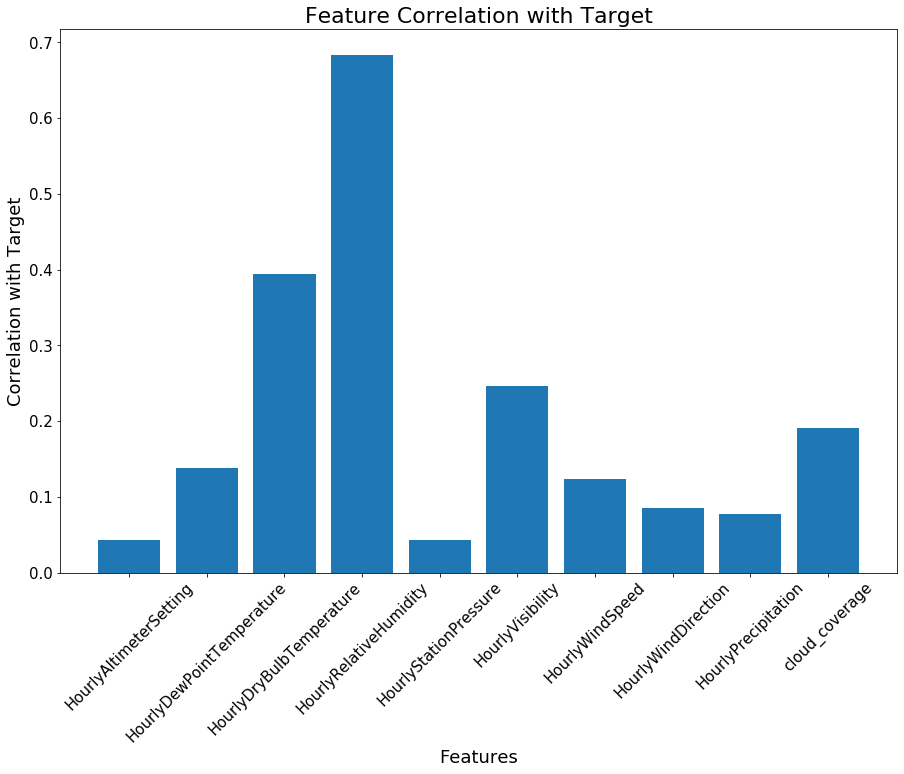

In [209]:
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(features, corr_mags)
ax.set_title('Feature Correlation with Target', fontsize=22)
ax.set_xlabel('Features', fontsize=18)
ax.set_ylabel('Correlation with Target', fontsize=18)
ax.tick_params(which='major', labelsize= 15)
ax.tick_params(axis='x', rotation=45)
# ax.set_xticks(rotation=45)


This plot makes it much easier to see which features are affecting the target variable. humidity and temperature have the two highest correlations, followed by visibility and cloud coverage. I want to create a few visualizations showing these relationships. I'll start with the first two: humidity and temperature.

### Correlation Visualizations

I want to begin by seeing how temperature and humidity vary over time, so I can compare those with the visualizations above showing how energy output varies with time. I'll begin by doing a basic plot of both over the time period, with a daily time frame.

In [210]:
weather_daily = weather_df.resample('D').mean()

Text(0, 0.5, 'Humidity %')

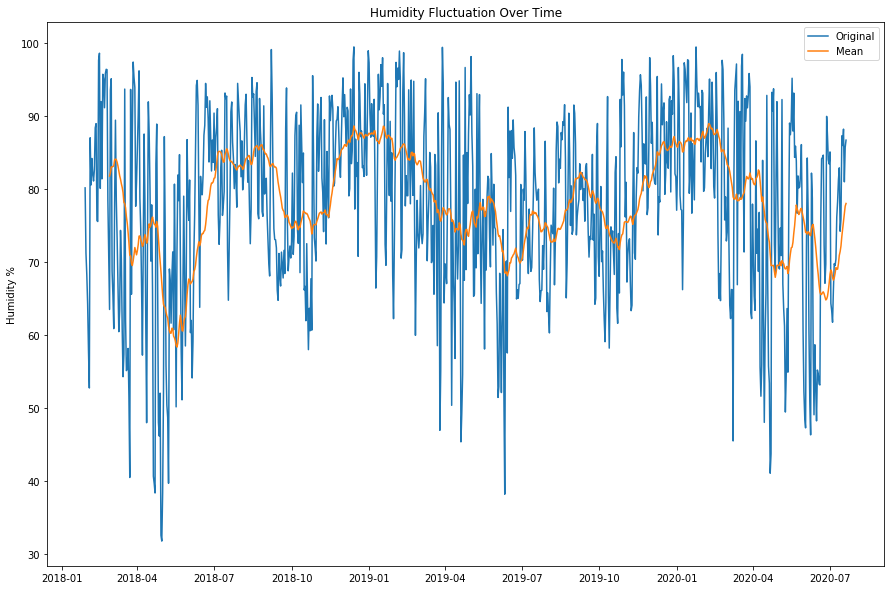

In [213]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(weather_daily['HourlyRelativeHumidity'], label='Original')
ax.plot(weather_daily['HourlyRelativeHumidity'].rolling(30).mean(), label='Mean')
ax.legend(loc='best')
ax.set_title('Humidity Fluctuation Over Time')
ax.set_ylabel('Humidity %')

The plot above showing a time series of relative humidity at a daily time stamp looks almost the opposite of the daily energy time series. This would make sense considering there was such a high negative correlation between the two, indicating an indirect relationship between the two variables. This is very apparent when looking at the 30 day rolling mean (same as energy plot from earlier). The overall trend is lower in Summer months and higher in Winter months, which is the oppostite of the energy trend. 

Since humidity is so strongly negatively correlated with energy production (-.68), this is likely a large reason for the decreased energy production in the winter months, since the overall trend of humidity is so much higher in these months. However, similar to energy production, humidity does have a lot of noise. There are many occurences of low humidity in a winter month and high humidity in summer months.

Now I want to look at the same type of plot, only for temperature.

Text(0, 0.5, 'Temperature (F)')

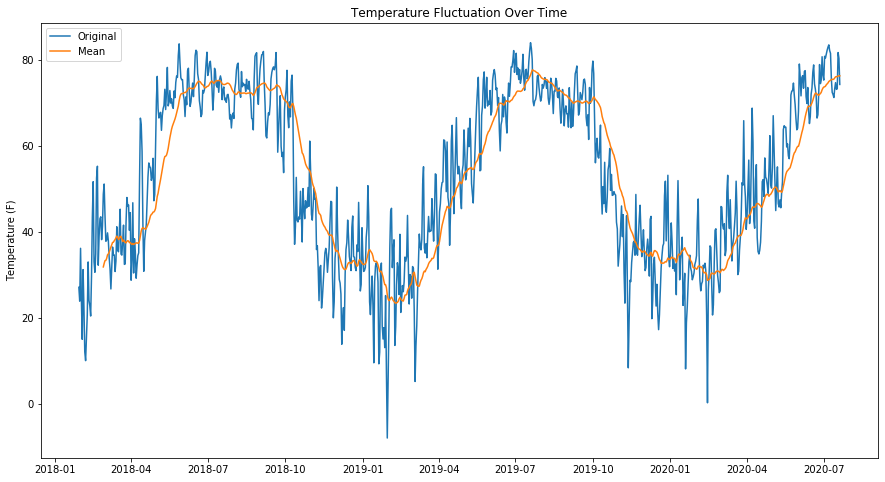

In [217]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(weather_daily['HourlyDryBulbTemperature'], label='Original')
ax.plot(weather_daily['HourlyDryBulbTemperature'].rolling(30).mean(), label='Mean')
ax.legend(loc='best')
ax.set_title('Temperature Fluctuation Over Time')
ax.set_ylabel('Temperature (F)')

The temperature values follow the overall trend much more tightly than the humidity or energy production do. This indicates that temperature does not usually change too dramatically over a short time period. It also means that temperature is much more consistent with the season than humidity. 

The next time I would like to do is plot the data all on a single plot so I can visually see the relationship between the three.

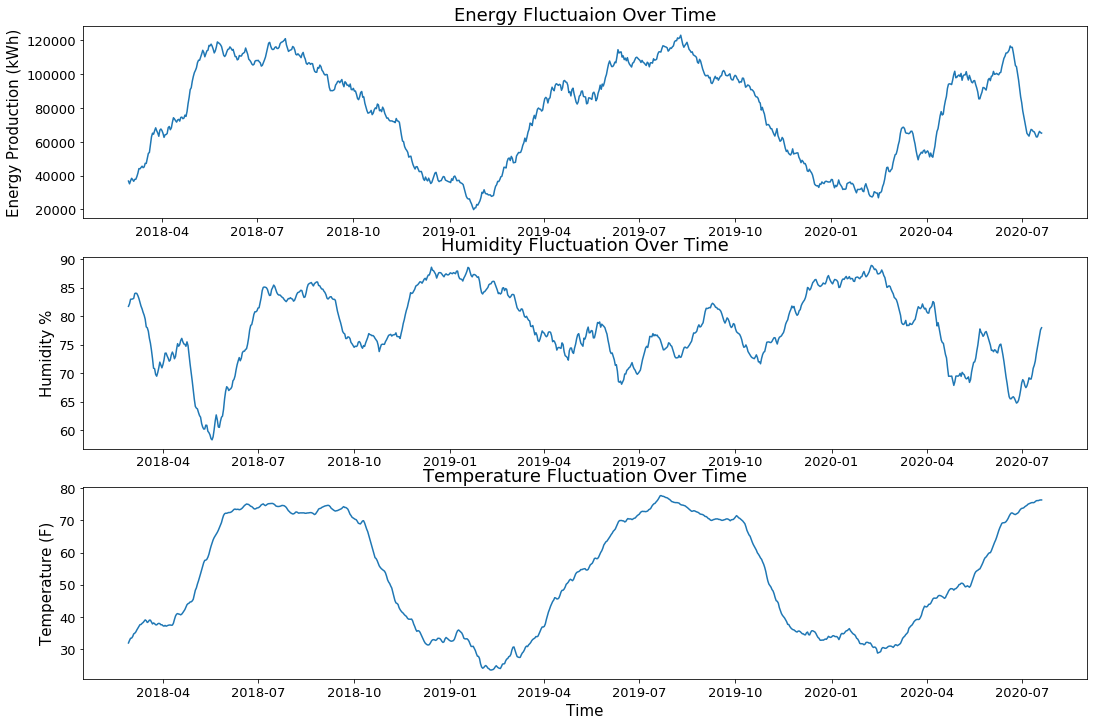

In [233]:
fig, ax = plt.subplots(3, 1, figsize=(18,12))
ax[0].plot(daily_roll_mean)
ax[0].set_title('Energy Fluctuaion Over Time', fontsize=18)
ax[0].set_ylabel('Energy Production (kWh)', fontsize=15)
ax[0].tick_params(which='major', labelsize= 13)
ax[1].plot(weather_daily['HourlyRelativeHumidity'].rolling(30).mean())
ax[1].set_title('Humidity Fluctuation Over Time', fontsize=18)
ax[1].set_ylabel('Humidity %', fontsize=15)
ax[1].tick_params(which='major', labelsize= 13)
ax[2].plot(weather_daily['HourlyDryBulbTemperature'].rolling(30).mean())
ax[2].set_title('Temperature Fluctuation Over Time', fontsize=18)
ax[2].set_xlabel('Time', fontsize=15)
ax[2].set_ylabel('Temperature (F)', fontsize=15)
ax[2].tick_params(which='major', labelsize= 13)

The above plot allows one to easily visualize the relationship between energy production and temperature and enery production and humidity. The temperatue and energy trends line up almost perfectly, indicating that overall, when temperatue rises energy production is likely to rise along with it. The humidity and energy plot do not line up as well, but you can see that when energy production is at it's minimums, humidity is at it's peak and vice versa.